In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Evaluate the Encoder-Decoder models

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from mlp_lhc_tomography.utils import unnormalize_params, minmax_normalize_param
from local_utils import fast_tensor_load_encdec
from local_models import Tomoscope
# from local_utils import get_best_model_timestamp

data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23'

train_cfg = {
    'normalization': 'minmax',
    'ps_normalize': 'default',
    'img_normalize': 'off',
    'dataset%': 0.1,
}

var_names = ['phEr', 'enEr', 'bl', 'inten', 'Vrf', 'mu', 'VrfSPS']

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
timestamp = 'best_encoder_TF'



2023-06-15 11:27:15.832446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 11:27:21.241575: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 11:27:21.867784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-06-15 11:27:21

In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TESTING_PATH = os.path.join(ML_dir, 'tomoscope-testing-??.npz')

np.random.seed(0)

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'
# assert train_cfg['ps_normalize'] == 'default'

# First the training data

start_t = time.time()
wf_test, turn_test, latent_test, ps_test = fast_tensor_load_encdec(
    TESTING_PATH, train_cfg['dataset%'])
print('Number of Testing files: ', len(turn_test))
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(turn_test):.3f}')

# read input, divide in features/ label, create tensors
# wf_test, turn_test, latent_test, ps_test = encdec_files_to_tensors(
#     file_names, normalization=normalization, img_normalize=img_normalize,
#     ps_normalize=ps_normalize)


Loading ./tomo_data/datasets_decoder_TF_24-03-23/ML_data/encdec-testing-00.npz


2023-06-15 11:27:50.248225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-06-15 11:27:50.266247: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-15 11:27:50.266283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-06-15 11:27:50.345338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

Loading ./tomo_data/datasets_decoder_TF_24-03-23/ML_data/encdec-testing-01.npz
Number of Testing files:  2931
Elapsed time: 23.620, Per file: 0.008


In [4]:
print('WF shape:', wf_test.shape)
print('Turn shape:', turn_test.shape)
print('Latent shape:', latent_test.shape)
print('PS shape:', ps_test.shape)

WF shape: (2931, 128, 128, 1)
Turn shape: (2931,)
Latent shape: (2931, 7)
PS shape: (2931, 128, 128, 1)


In [7]:
# Models to load
print('Tomoscope: ', timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
plots_dir = os.path.join('./trials/', timestamp, 'plots')
os.makedirs(plots_dir, exist_ok=True)

weights_dir = os.path.join(trial_dir, 'weights')
assert os.path.exists(weights_dir)

tomoscope = Tomoscope()
tomoscope.load(weights_dir=weights_dir)


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF


92/92 [==============================] - 4s 42ms/step


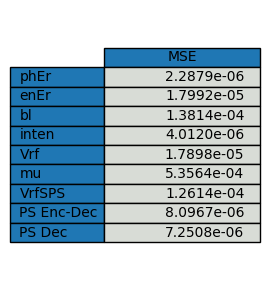

In [9]:

# Evaluate the model on the test and validation data
ps_pred = tomoscope.predict(wf_test)

# Evaluate the PS agreement
ps_mse = np.mean((ps_test[:, 14:-14, 14:-14] - ps_pred[:, 14:-14, 14:-14])**2,
                          axis=0).reshape((100, 100))
print('\nPS Tomoscope MSE: ', np.mean(ps_mse))

PS True, min: 0.0, max: 0.01854899525642395
PS Pred, min: -0.0013223628047853708, max: 0.01621103473007679


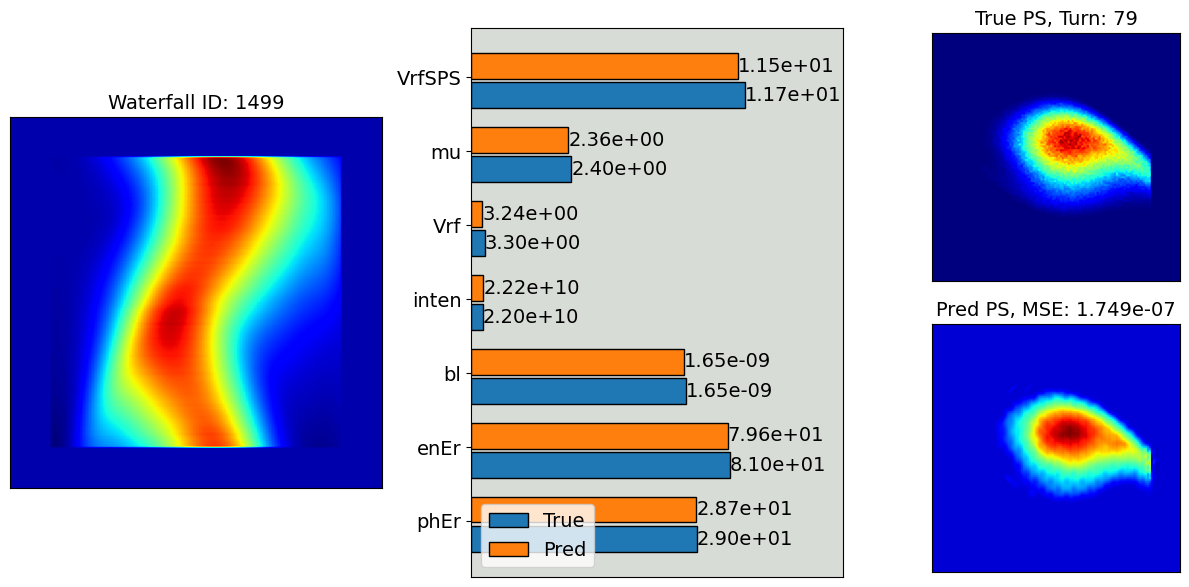

In [12]:
# Here we need animation with WF on the left, real PS in the middle, predicted on the right
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'TAB', 'PS_TRUE'],
                                       ['WF', 'TAB', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 2]},
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(12, 6))

# fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'WF', 'TAB'],
#                                        ['PS_TRUE', 'PS_PRED', 'TAB']],
#                                gridspec_kw={'width_ratios': [2, 2, 4]},
#                                #        'hspace': 0.1, 'wspace': 0.2},
#                                figsize=(8, 8))

# get random id
sample_id = np.random.randint(low=0, high=len(turn_test))
wf_s = np.array(wf_test[sample_id]).reshape(128, 128).T
latent_true_s = latent_unnorm[sample_id]
latent_pred_s = latent_pred_unnorm[sample_id]
latent_norm_true_s = np.array(latent_test[sample_id])
latent_norm_pred_s = np.array(latent_pred[sample_id])

turn_s = turn_test[sample_id]
# turn_s = int(unnormalizeTurn(turn_s, maxTurns=300))
turn_s = int(minmax_normalize_param(turn_s, 0, 1, target_range=(1, 298)))
ps_true_s = ps_test[sample_id]
ps_pred_s = ps_pred[sample_id]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# center plot
plt.sca(axes['TAB'])
plt.gca().set_facecolor('xkcd:light grey')
# Remove inten, since it is very hard to predict
# latent_true_s = np.delete(latent_true_s, var_names.index('inten'))
# latent_pred_s = np.delete(latent_pred_s, var_names.index('inten'))
# latent_norm_true_s = np.delete(latent_norm_true_s, var_names.index('inten'))
# latent_norm_pred_s = np.delete(latent_norm_pred_s, var_names.index('inten'))

reduced_var_names = var_names.copy()
# reduced_var_names.remove('inten')

# add the true values
bars = plt.barh(np.arange(len(latent_true_s)),
                height=0.35, width=(latent_norm_true_s),
                edgecolor='black', label='True')

# annotate the true values
for idx, width in enumerate(latent_norm_true_s):
    plt.annotate(f'{latent_true_s[idx]:.2e}',
                 xy=(width, idx),
                 ha='left', va='center',
                 fontsize=14)
    
# add the predicted values
plt.barh(np.arange(len(latent_true_s)) + 0.4,
         height=0.35, width=latent_norm_pred_s,
         edgecolor='black', label='Pred')

# annotate the predicted values
for idx, width in enumerate(latent_norm_pred_s):
    plt.annotate(f'{latent_pred_s[idx]:.2e}',
                 xy=(width, idx+0.4),
                 ha='left', va='center',
                 fontsize=14)
plt.xlim(0, 1.3)
plt.yticks(np.arange(len(latent_true_s))+0.25, reduced_var_names, fontsize=14)
plt.xticks([], [])
plt.legend(loc='lower left',fontsize=14)

# top right plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
plt.imshow(ps_true_s, cmap='jet')
plt.title(f'True PS, Turn: {turn_s}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# bottom right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
plt.imshow(ps_pred_s, cmap='jet')
plt.title(f'Pred PS, MSE: {np.mean((ps_pred_s - ps_true_s)**2):.3e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()

plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)


In [16]:
from mlp_lhc_tomography.utils import assess_decoder
num_samples = 20
assess_decoder(ps_pred[:num_samples], turn_test[:num_samples], ps_test[:num_samples],
               plots_dir=plots_dir, savefig=True)


In [13]:
from mlp_lhc_tomography.utils import assess_model
num_samples = 20
assess_model(ps_pred[:num_samples], turn_test[:num_samples], wf_test[:num_samples], ps_test[:num_samples],
             plots_dir=plots_dir, savefig=True, with_projections=True)
